<a href="https://colab.research.google.com/github/namanphy/Controllable-Image-Captioning-App/blob/master/S5/eva_session5%20-%20iter%202.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Iteration 2




Target
1. To reduce the number of parameters.

Results
1. parameters = 8,734
2. Best Train Accuracy = 99.34
3. Best Test Accuracy = 99.00

Analysis
1. Good training accuracy with reduced number of parameters.
2. Overfitting - The model is still overfitting.
3. Also the best training and test accuracies are reduced.
4. Number of model parameters is under required target.

---

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

!pip install torchsummary
from torchsummary import summary

## Getting to know our data

In [ ]:
# Downloading the dataset and setting up dataloader for visualisationn only

train_set = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
test_set = datasets.MNIST('../data', train=False, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)

/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:58: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1307)
 - std: tensor(0.3081)
 - var: tensor(0.0949)

torch.Size([64, 1, 28, 28])
torch.Size([64])




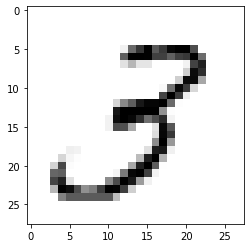

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train_set.train_data
train_data = train_set.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train_set.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train_set.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

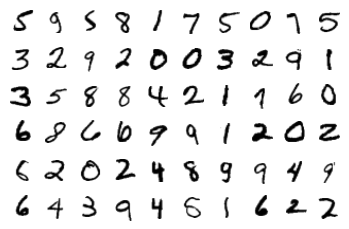

In [ ]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

## Setting up Dataloaders and Transformations


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [ ]:
torch.manual_seed(1)
if use_cuda:
    torch.cuda.manual_seed(1)
batch_size = 128

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

train_set = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_set = datasets.MNIST('../data', train=False, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_set , batch_size=batch_size, shuffle=True, **kwargs)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)


## Making our model

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 10, 3, padding=1, bias=False), # RF - 3x3
            nn.ReLU(), # RF - 3x3
            nn.Conv2d(10, 10, 3, bias=False), # RF - 5x5
            nn.ReLU(), # RF - 5x5
            nn.MaxPool2d(2, 2) # RF - 10x10
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(10, 16, 3, padding=1, bias=False), # RF - 12x12
            nn.ReLU(), # RF - 12x12
            nn.Conv2d(16, 16, 3, bias=False), # RF - 14x14
            nn.ReLU(), # RF - 14x14
            nn.MaxPool2d(2, 2) # RF - 28x28
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 10, 5, bias=False)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        # x = x.mean(dim=[-2,-1])
        x = x.view(-1, 10)
        return F.log_softmax(x)

In [ ]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 28, 28]              90
              ReLU-2           [-1, 10, 28, 28]               0
            Conv2d-3           [-1, 10, 26, 26]             900
              ReLU-4           [-1, 10, 26, 26]               0
         MaxPool2d-5           [-1, 10, 13, 13]               0
            Conv2d-6           [-1, 16, 13, 13]           1,440
              ReLU-7           [-1, 16, 13, 13]               0
            Conv2d-8           [-1, 16, 11, 11]           2,304
              ReLU-9           [-1, 16, 11, 11]               0
        MaxPool2d-10             [-1, 16, 5, 5]               0
           Conv2d-11             [-1, 10, 1, 1]           4,000
Total params: 8,734
Trainable params: 8,734
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
    print(f"EPOCH - {epoch}")
    model.train()
    pbar = tqdm(train_loader, position=0, leave=True)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_losses.append(loss)
        loss.backward()
        optimizer.step()

        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_acc.append(100*correct/processed)


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), 100. * correct / len(test_loader.dataset)))
    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
data, target = next(iter(train_loader))
print(data.size(), target.size())

torch.Size([128, 1, 28, 28]) torch.Size([128])


In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 16):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)


  0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=2.307953119277954 Batch_id=0 Accuracy=7.03:   0%|          | 1/469 [00:00<01:27,  5.35it/s]

EPOCH - 1


Loss=0.09776719659566879 Batch_id=468 Accuracy=84.85: 100%|██████████| 469/469 [00:59<00:00,  7.91it/s]
Loss=0.0802985355257988 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<01:03,  7.39it/s]


Test set: Average loss: 0.0851, Accuracy: 9739/10000 (97%)

EPOCH - 2


Loss=0.06484547257423401 Batch_id=468 Accuracy=97.58: 100%|██████████| 469/469 [01:06<00:00,  7.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0584, Accuracy: 9806/10000 (98%)

EPOCH - 3


Loss=0.021484365686774254 Batch_id=468 Accuracy=98.13: 100%|██████████| 469/469 [01:03<00:00,  7.38it/s]
Loss=0.04014552757143974 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:01,  7.64it/s]


Test set: Average loss: 0.0434, Accuracy: 9875/10000 (99%)

EPOCH - 4


Loss=0.011440792120993137 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [01:02<00:00,  7.47it/s]
Loss=0.038436390459537506 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<01:02,  7.44it/s]


Test set: Average loss: 0.0399, Accuracy: 9861/10000 (99%)

EPOCH - 5


Loss=0.03050914965569973 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [01:03<00:00,  7.41it/s]
Loss=0.07223913818597794 Batch_id=0 Accuracy=97.66:   0%|          | 1/469 [00:00<01:05,  7.15it/s]


Test set: Average loss: 0.0458, Accuracy: 9852/10000 (99%)

EPOCH - 6


Loss=0.00786848459392786 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [01:03<00:00,  7.36it/s]
Loss=0.01417743880301714 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:02,  7.53it/s]


Test set: Average loss: 0.0326, Accuracy: 9893/10000 (99%)

EPOCH - 7


Loss=0.006660646293312311 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [01:03<00:00,  7.33it/s]
Loss=0.007397185079753399 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:01,  7.58it/s]


Test set: Average loss: 0.0365, Accuracy: 9877/10000 (99%)

EPOCH - 8


Loss=0.003984513226896524 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [01:03<00:00,  7.39it/s]
Loss=0.005963130388408899 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:01,  7.60it/s]


Test set: Average loss: 0.0324, Accuracy: 9892/10000 (99%)

EPOCH - 9


Loss=0.009622329846024513 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [01:03<00:00,  7.43it/s]
Loss=0.008168710395693779 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:04,  7.31it/s]


Test set: Average loss: 0.0372, Accuracy: 9870/10000 (99%)

EPOCH - 10


Loss=0.01401546597480774 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [01:02<00:00,  7.50it/s]
Loss=0.0761067271232605 Batch_id=0 Accuracy=98.44:   0%|          | 1/469 [00:00<01:01,  7.57it/s]


Test set: Average loss: 0.0317, Accuracy: 9897/10000 (99%)

EPOCH - 11


Loss=0.006085806060582399 Batch_id=468 Accuracy=99.15: 100%|██████████| 469/469 [01:03<00:00,  7.44it/s]
Loss=0.023349160328507423 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:01,  7.59it/s]


Test set: Average loss: 0.0398, Accuracy: 9870/10000 (99%)

EPOCH - 12


Loss=0.02801460213959217 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [01:02<00:00,  7.50it/s]
Loss=0.017225665971636772 Batch_id=0 Accuracy=99.22:   0%|          | 1/469 [00:00<01:00,  7.73it/s]


Test set: Average loss: 0.0385, Accuracy: 9881/10000 (99%)

EPOCH - 13


Loss=0.01608692668378353 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [01:03<00:00,  7.44it/s]
Loss=0.006821321789175272 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:01,  7.59it/s]


Test set: Average loss: 0.0509, Accuracy: 9853/10000 (99%)

EPOCH - 14


Loss=0.004216733854264021 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [01:02<00:00,  7.52it/s]
Loss=0.005629427265375853 Batch_id=0 Accuracy=100.00:   0%|          | 1/469 [00:00<01:05,  7.18it/s]


Test set: Average loss: 0.0327, Accuracy: 9891/10000 (99%)

EPOCH - 15


Loss=0.005759489256888628 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [01:02<00:00,  7.52it/s]



Test set: Average loss: 0.0329, Accuracy: 9897/10000 (99%)



Text(0.5, 1.0, 'Test Accuracy')

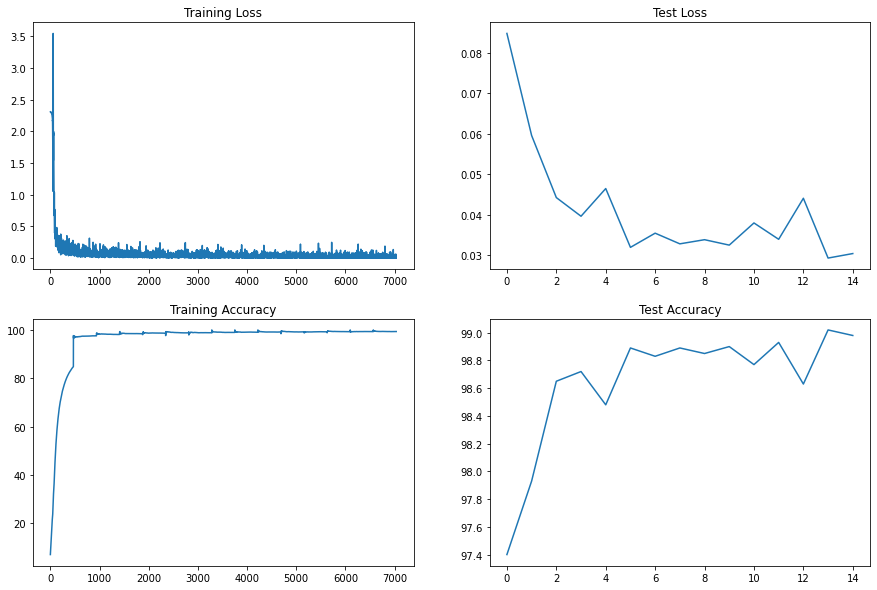

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")